In [1]:
import kagglehub

import warnings
warnings.simplefilter("ignore")

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

c:\Users\mia.jensen\Anaconda3\envs\Python_3_11_3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-create-a-neural-network-for-regression-with-pytorch.md

In [2]:
path = kagglehub.dataset_download("budincsevity/szeged-weather")
file_name = "weatherHistory.csv"
df = pd.read_csv(path + "\\" + file_name)

# view
print(df.shape)
display(df.head())
display(df.describe())

# drop columns
df = df.drop(columns=["Formatted Date", "Daily Summary", "Loud Cover", "Apparent Temperature (C)"])

# rename columns
df.columns = ['Summary', 'PrecipType', 'Temp', 'Humidity', 'WindSpeed', 'WindBearing', 'Visibility', 'Pressure']

# convert summary to dummy
mlb = MultiLabelBinarizer()
SummarySplit = df["Summary"].str.lower().str.split(' and ')
dummies_summary = pd.DataFrame(mlb.fit_transform(SummarySplit), columns=mlb.classes_, index=df.index).iloc[:,1:].reset_index(drop=True)
df = df.drop(columns=["Summary"])

# convert precip type to dummy 
dummies_precip_type = pd.get_dummies(df["PrecipType"], drop_first=True).astype(int).reset_index(drop=True)
df = df.drop(columns=["PrecipType"])

# join to full dataframe
df = pd.concat([df, dummies_summary, dummies_precip_type], axis=1)
df

(96453, 12)


,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars)
count,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.0,96453.000000
mean,11.932678,10.855029,0.734899,10.810640,187.509232,10.347325,0.0,1003.235956
std,9.551546,10.696847,0.195473,6.913571,107.383428,4.192123,0.0,116.969906
min,-21.822222,-27.716667,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,4.688889,2.311111,0.600000,5.828200,116.000000,8.339800,0.0,1011.900000
50%,12.000000,12.000000,0.780000,9.965900,180.000000,10.046400,0.0,1016.450000
75%,18.838889,18.838889,0.890000,14.135800,290.000000,14.812000,0.0,1021.090000
max,39.905556,39.344444,1.000000,63.852600,359.000000,16.100000,0.0,1046.380000


,Temp,Humidity,WindSpeed,WindBearing,Visibility,Pressure,clear,dangerously windy,drizzle,dry,foggy,humid,light rain,mostly cloudy,overcast,partly cloudy,rain,windy,snow
0,9.472222,0.89,14.1197,251.0,15.8263,1015.13,0,0,0,0,0,0,0,0,0,1,0,0,0
1,9.355556,0.86,14.2646,259.0,15.8263,1015.63,0,0,0,0,0,0,0,0,0,1,0,0,0
2,9.377778,0.89,3.9284,204.0,14.9569,1015.94,0,0,0,0,0,0,0,1,0,0,0,0,0
3,8.288889,0.83,14.1036,269.0,15.8263,1016.41,0,0,0,0,0,0,0,0,0,1,0,0,0
4,8.755556,0.83,11.0446,259.0,15.8263,1016.51,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96448,26.016667,0.43,10.9963,31.0,16.1000,1014.36,0,0,0,0,0,0,0,0,0,1,0,0,0
96449,24.583333,0.48,10.0947,20.0,15.5526,1015.16,0,0,0,0,0,0,0,0,0,1,0,0,0
96450,22.038889,0.56,8.9838,30.0,16.1000,1015.66,0,0,0,0,0,0,0,0,0,1,0,0,0
96451,21.522222,0.60,10.5294,20.0,16.1000,1015.95,0,0,0,0,0,0,0,0,0,1,0,0,0


In [3]:
# split datasets in y (response) and X (predictors) 
# for train, test, and validation sets

response = "Temp"

y = df[[response]]
X = df.drop(columns=[response])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [4]:
#normalise data so it's all on the same scale
scaler = StandardScaler()

X_train_norm = pd.DataFrame(scaler.fit_transform(X_train.iloc[:,1:]), columns=X_train.columns[1:])
y_train_norm = scaler.fit_transform(y_train)

X_test_norm = pd.DataFrame(scaler.fit_transform(X_test.iloc[:,1:]), columns=X_test.columns[1:])
y_test_norm = scaler.fit_transform(y_test)

X_val_norm = pd.DataFrame(scaler.fit_transform(X_val.iloc[:,1:]), columns=X_val.columns[1:])
y_val_norm = scaler.fit_transform(y_val)

In [5]:
# Convert the pandas DataFrames to PyTorch tensors
X_train_tensor = torch.tensor(X_train_norm.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test_norm.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

X_val_tensor = torch.tensor(X_val_norm.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)

In [6]:
# # Create a TensorDataset and DataLoader
# dataset = TensorDataset(X_train_tensor, y_train_tensor)
# dataloader = DataLoader(dataset, batch_size=16, shuffle=True) 

In [7]:
# # Define the model
# class RegressionNN(nn.Module):
#     def __init__(self, input_dim):
#         super().__init__()
#         self.model = nn.Sequential(
#             nn.Linear(input_dim, 64),
#             nn.ReLU(),
#             nn.Linear(64, 32),
#             nn.ReLU(),
#             # nn.Dropout(0.2),
#             nn.Linear(32, 1)
#         )
#     def forward(self, x):
#         return self.model

In [8]:
# # Instantiate the Model, Loss Function, and Optimizer
# model = RegressionNN(input_dim = X_train_norm.shape[1])
# criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [9]:
# # Train the model 
# num_epochs = 10
# df_loss = pd.DataFrame()
# for epoch in range(num_epochs):
#     # Forward pass
#     outputs = model(X_train_tensor)
#     loss = criterion(outputs, y_train_tensor)
    
#     # Backward pass and optimization
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

#     if (epoch+1) % 2 == 0:
#         print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
#         df_loss = pd.concat([df_loss, pd.DataFrame([{"Epoch": epoch+1, "Loss": loss.item()}])])

# print("Training complete.")

In [10]:
# # Test the Model
# with torch.no_grad():
#     print(f'Test Input: {X_val_tensor.numpy()}, Predicted Output: {y_val_tensor.numpy()}')

In [11]:
# Define the model
class MLP(nn.Module):
  '''
    Multilayer Perceptron for regression.
  '''
  def __init__(self, input_dim):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(input_dim, 64),
      nn.ReLU(),
      nn.Linear(64, 32),
      nn.ReLU(),
      nn.Linear(32, 1)
    )
  def forward(self, x):
    '''
      Forward pass
    '''
    return self.layers(x)

In [12]:
# Create a TensorDataset and DataLoader
dataset = TensorDataset(X_train_tensor, y_train_tensor)
dataloader = DataLoader(dataset, batch_size=10, shuffle=True, num_workers=1)

In [13]:
# Instantiate the Model, Loss Function, and Optimizer
mlp = MLP(input_dim = X_train_norm.shape[1])
loss_function = nn.L1Loss()
optimizer = optim.Adam(mlp.parameters(), lr = 0.001)

Epoch [500/10000], Loss: 5.3540
Epoch [1000/10000], Loss: 4.9132
Epoch [1500/10000], Loss: 4.7011
Epoch [2000/10000], Loss: 4.6307
Epoch [2500/10000], Loss: 4.5916
Epoch [3000/10000], Loss: 4.5688
Epoch [3500/10000], Loss: 4.5548
Epoch [4000/10000], Loss: 4.5433
Epoch [4500/10000], Loss: 4.5353
Epoch [5000/10000], Loss: 4.5286
Epoch [5500/10000], Loss: 4.5216
Epoch [6000/10000], Loss: 4.5157
Epoch [6500/10000], Loss: 4.5109
Epoch [7000/10000], Loss: 4.5054
Epoch [7500/10000], Loss: 4.5016
Epoch [8000/10000], Loss: 4.4982
Epoch [8500/10000], Loss: 4.4943
Epoch [9000/10000], Loss: 4.4907
Epoch [9500/10000], Loss: 4.4871
Epoch [10000/10000], Loss: 4.4832
Training complete.


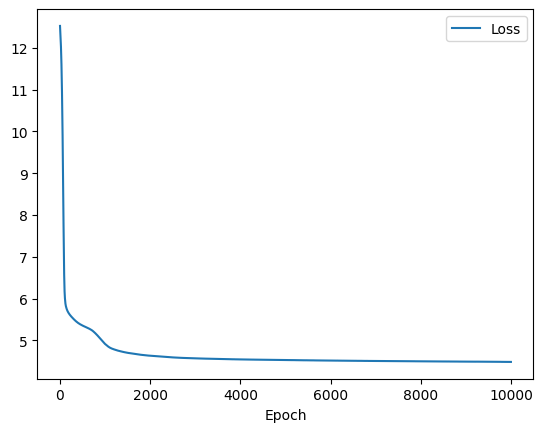

In [14]:
# Train the model 
num_epochs = 10000
df_loss = pd.DataFrame()
for epoch in range(num_epochs):
    # Forward pass
    outputs = mlp(X_train_tensor)
    loss = loss_function(outputs, y_train_tensor)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 500 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    
    df_loss = pd.concat([df_loss, pd.DataFrame([{"Epoch": epoch+1, "Loss": loss.item()}])])

print("Training complete.")

df_loss.plot(kind="line", x="Epoch", y="Loss")
plt.show()

In [15]:
# Test the Model
with torch.no_grad():
    print(f'Test Input: {X_val_tensor.numpy()}, Predicted Output: {y_val_tensor.numpy()}')

Test Input: [[ 0.40316695  0.89491093  1.0886476  ... -0.01247145 -0.0426335
  -0.35628977]
 [ 0.03557004 -0.6859824  -0.811439   ... -0.01247145 -0.0426335
   2.8067043 ]
 [-0.2217478   0.0300693  -0.0859514  ... -0.01247145 -0.0426335
  -0.35628977]
 ...
 [-1.097088    1.2482871  -1.8516884  ... -0.01247145 -0.0426335
   2.8067043 ]
 [-1.0028912  -0.6580843  -1.6904689  ... -0.01247145 -0.0426335
  -0.35628977]
 [-0.19188054  0.42064294 -0.0859514  ... -0.01247145 -0.0426335
  -0.35628977]], Predicted Output: [[ 4.4333334e+00]
 [-1.1111111e-02]
 [ 2.7799999e+01]
 ...
 [-1.0000000e+01]
 [ 7.5999999e+00]
 [ 2.8861111e+01]]
